In [1]:
from dataset import CUBDataset, FGVCAircraft, FOODDataset
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset 
import torch
from torch.utils.data import default_collate

from matplotlib import pyplot as plt

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASSES = 200

transforms_train = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=(0.5, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(-90, 90)),
    v2.RandomAffine(degrees=(-15, 15), translate=(0.25, 0.25), scale=(0.7, 1.3), shear=(-15, 15, -15, 15)),
    # v2.RandomPerspective(distortion_scale=0.1, p=0.2),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomAutocontrast(p=0.2),
    v2.RandomEqualize(p=0.2),

    v2.ToDtype(torch.float, scale=True),
    v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])
transforms_test = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224), antialias=True),
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [12]:
dataset_name = 'CUB'

if dataset_name == 'CUB':
    dataset_path = "/apps/local/shared/CV703/datasets/CUB/CUB_200_2011"

    train_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_train, split="train")
    test_dataset = CUBDataset(image_root_path=dataset_path, transform=transforms_test, split="test")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

    class_names = train_dataset.classes

elif dataset_name == 'CUB and FGVC-Aircraft':
    dataset_path_cub = "/apps/local/shared/CV703/datasets/CUB/CUB_200_2011"
    train_dataset_cub = CUBDataset(image_root_path=dataset_path_cub, transform=transforms_train, split="train")
    test_dataset_cub = CUBDataset(image_root_path=dataset_path_cub, transform=transforms_test, split="test")

    dataset_path_aircraft = "/apps/local/shared/CV703/datasets/fgvc-aircraft-2013b"
    train_dataset_aircraft = FGVCAircraft(root=dataset_path_aircraft, transform=transforms_train, train=True)
    test_dataset_aircraft = FGVCAircraft(root=dataset_path_aircraft, transform=transforms_test, train=False)

    concat_dataset_train = ConcatDataset([train_dataset_cub, train_dataset_aircraft])
    concat_dataset_test = ConcatDataset([test_dataset_cub, test_dataset_aircraft])

    train_loader = torch.utils.data.DataLoader(
                concat_dataset_train,
                batch_size=BATCH_SIZE, shuffle=True,
                num_workers=8, pin_memory=True
                )
    test_loader = torch.utils.data.DataLoader(
                concat_dataset_test,
                batch_size=BATCH_SIZE, shuffle=False,
                num_workers=8, pin_memory=True
                )
    
    classes_1 = concat_dataset_train.datasets[0].classes
    classes_2 = concat_dataset_train.datasets[1].classes

    class_names = [*classes_1, *classes_2]

elif dataset_name == 'FoodX':
    dataset_path = "/apps/local/shared/CV703/datasets/FoodX/food_dataset"

    train_dataset = FOODDataset(data_dir=dataset_path, transform=transforms_train, split="train")
    test_dataset = FOODDataset(data_dir=dataset_path, transform=transforms_test, split="test")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


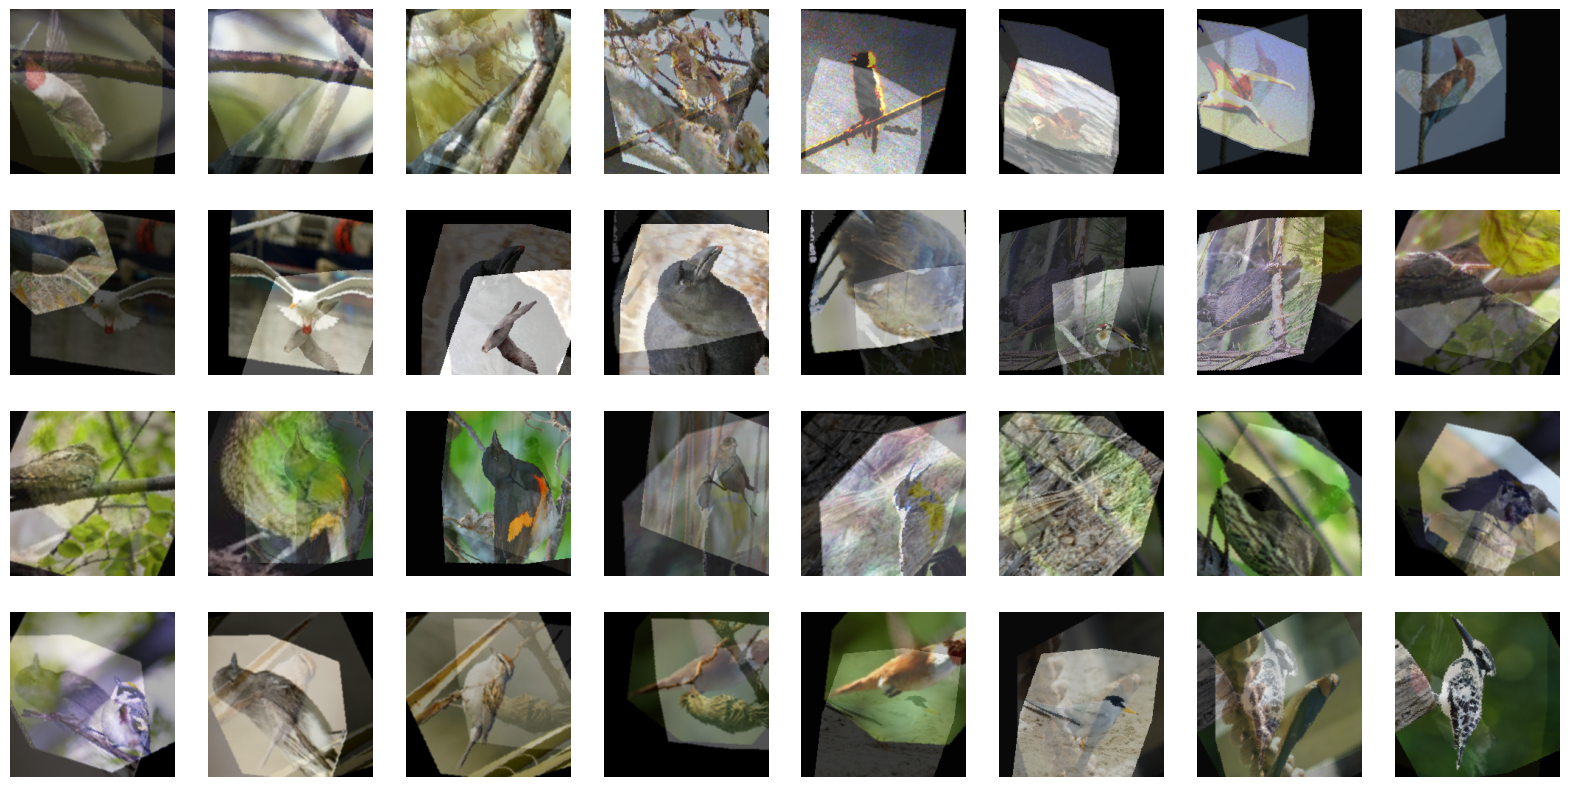

In [15]:
# plot batch of images
def plot_batch(batch):
    images, labels = batch
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        # remove normalization
        image = image * torch.tensor([0.229,0.224,0.225]) + torch.tensor([0.485,0.456,0.406])
        ax.imshow(image)

        # label = labels[i].item()
        # label = class_names[label]
        # ax.set_title(label)
        ax.axis('off')
    plt.show()

plot_batch(next(iter(train_loader)))

In [5]:
print(len(train_dataset))
print(len(test_dataset))

5994
5794
